In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import seaborn as sns
#Baseline
from sklearn.linear_model import LogisticRegression

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2, f_classif, SelectKBest

# For matrics
from scipy.sparse import csr_matrix

# Factorization
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from catboost import CatBoostClassifier, Pool

#Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2, f_classif
pd.options.display.float_format ='{:,.2f}'.format
%matplotlib inline

In [2]:
train = pd.read_csv('my_train.csv')
test = pd.read_csv('my_test.csv')

In [3]:
train.shape

(860052, 258)

In [4]:
train = train.drop(['buy_time_x','buy_time_y'], axis=1)

In [5]:
train.vas_id = train.vas_id.apply(lambda x: int(x))

In [6]:
train.target = train.target.apply(lambda x: int(x))

In [7]:
test.vas_id = test.vas_id.apply(lambda x: int(x))

In [8]:
train_users = train.id.tolist()
test_users = test.id.tolist()

In [9]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [10]:
y = train['target']
train = train.drop('target', axis=1)

In [11]:
# train = train.drop(const_feat, axis=1)
# test = test.drop(const_feat, axis=1)

In [12]:
train.head(5)

vas_id      0      1       2       3       4       5      6      7     8  \
0       8 -31.56 327.36  -45.50  274.75  -50.92  253.65  49.15 195.88 -1.84   
1       4 547.27 238.43  533.33  274.80  527.91  253.70 -16.09 -65.08 -6.78   
2       1 -92.14 -95.47 -106.08 -139.60 -111.50 -142.90 -16.09 -65.08 -6.78   
3       5  54.88  12.97   54.08   -9.12   48.66  -30.22  60.17  87.45 -6.78   
4       1  45.16 295.24   64.68  344.28   59.26  323.18 -16.09 -65.08 -6.78   

   ...     243     244    245    246     247    248   249    250   251  252  
0  ... -845.37 -613.77 -21.00 -37.63  -28.75   4.17  7.31 -12.18 21.54 0.00  
1  ... -972.37 -613.77 -26.00 -19.63 -278.75 -24.83 -0.69 -11.18 -0.46 0.00  
2  ... -977.37 -613.77 -26.00 -37.63 -304.75 -25.83 -0.69 -12.18 -0.46 0.00  
3  ... -977.37 -613.77 -26.00 -18.63 -133.75 -14.83 -0.69  -1.18 -0.46 0.00  
4  ... -965.37 -612.77 -23.00 -32.63 -127.75  -4.83 -0.69 -12.18 -0.46 0.00  

[5 rows x 254 columns]

In [13]:
# del features_df_new

In [14]:
selector = SelectKBest(f_classif, k=50)
selector.fit(train, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
# features_df_new = train.iloc[:,cols]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 76  82  86 140 204] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [15]:
train = train.iloc[:,cols]

In [16]:
test = test.iloc[:, cols]

In [17]:
train_idx, test_idx = train_test_split(train.index, test_size=0.25, random_state=21)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = train.loc[train_idx], train.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0   0.93
1   0.07
Name: target, dtype: float64

Test
0   0.93
1   0.07
Name: target, dtype: float64


In [18]:
all_f =  train.nunique()
all_f[all_f == 1].index
const_feat = all_f[all_f == 1].index
cat_feat = all_f[all_f <= 10].index

In [38]:
cat_feat

Index(['vas_id', '31', '192', '194', '195', '196', '198', '200', '201', '205'], dtype='object')

In [20]:
all_f[all_f > 10].index

Index(['1', '3', '4', '5', '18', '20', '22', '38', '39', '42', '59', '68',
       '108', '112', '114', '115', '116', '117', '124', '125', '130', '134',
       '136', '138', '144', '145', '146', '165', '167', '193', '207', '210',
       '224', '225', '226', '235', '236', '240', '241', '245'],
      dtype='object')

In [21]:
all_f.index

Index(['vas_id', '1', '3', '4', '5', '18', '20', '22', '31', '38', '39', '42',
       '59', '68', '108', '112', '114', '115', '116', '117', '124', '125',
       '130', '134', '136', '138', '144', '145', '146', '165', '167', '192',
       '193', '194', '195', '196', '198', '200', '201', '205', '207', '210',
       '224', '225', '226', '235', '236', '240', '241', '245'],
      dtype='object')

In [23]:
for cat in cat_feat:
    X_train[cat] = X_train[cat].apply(lambda x: int(x))

In [27]:
for cat in cat_feat:
    X_test[cat] = X_test[cat].apply(lambda x: int(x))

In [24]:
model = CatBoostClassifier(iterations=1000,
                           depth=10, 
                           l2_leaf_reg=5,
                           loss_function='Logloss', #Logloss
                           learning_rate=0.1,
                           metric_period=100,
                           cat_features=cat_feat,
                    
                          )
model.fit(X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5492682	total: 322ms	remaining: 5m 21s
100:	learn: 0.1786886	total: 20.7s	remaining: 3m 4s
200:	learn: 0.1727374	total: 41.5s	remaining: 2m 44s
300:	learn: 0.1669591	total: 1m 2s	remaining: 2m 24s
400:	learn: 0.1615847	total: 1m 23s	remaining: 2m 4s
500:	learn: 0.1571236	total: 1m 44s	remaining: 1m 43s
600:	learn: 0.1519216	total: 2m 5s	remaining: 1m 23s
700:	learn: 0.1473082	total: 2m 26s	remaining: 1m 2s
800:	learn: 0.1425740	total: 2m 47s	remaining: 41.5s
900:	learn: 0.1382714	total: 3m 8s	remaining: 20.7s
999:	learn: 0.1339445	total: 3m 28s	remaining: 0us


In [28]:
y_pred = model.predict(X_test)

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    199526
           1       0.38      0.08      0.14     15487

    accuracy                           0.92    215013
   macro avg       0.66      0.54      0.55    215013
weighted avg       0.89      0.92      0.90    215013



In [30]:
f1_score(y_test, y_pred, average='macro')

0.5486290679033486

In [31]:
y_pred_proba_1 = model.predict_proba(X_test)

<AxesSubplot:>

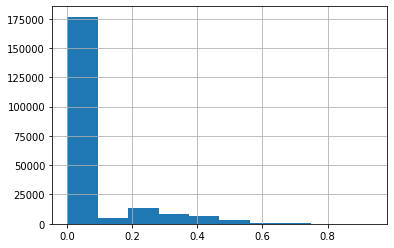

In [32]:
pd.Series(y_pred_proba_1[:, 1]).hist()

In [33]:
predict = np.where(y_pred_proba_1[:, 1] > 0.4, 1, 0)

In [34]:
print(classification_report(predict, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    205557
           1       1.00      0.35      0.52      9456

    accuracy                           0.97    215013
   macro avg       0.99      0.68      0.75    215013
weighted avg       0.97      0.97      0.97    215013



In [35]:
f1_score(predict, y_pred, average='macro')

0.75463153237873

In [36]:
import pickle

In [37]:
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
# with open("model.pkl", "rb") as f:
#     model = pickle.load(f)

In [ ]:
y_pred_proba_1 = model.predict_proba(X_test)

In [ ]:
pd.Series(y_pred_proba_1[:, 1]).hist()

In [ ]:
test.head(3)

In [ ]:
test = test[all_f.index]

In [ ]:
test

In [ ]:
y_pred_proba_1 = model.predict_proba(test)[: , 1]

In [ ]:
pd.DataFrame({'id': test_users, 'vas_id': test.vas_id.tolist(), 'target': y_pred_proba_1})